In [ ]:
import os
from pathlib import Path

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class Create_Dataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.samples = []
        self.transform = transform

        real_dir = Path(real_dir)
        fake_dir = Path(fake_dir)

        # Collect real images (label 0)
        for ext in ["*.jpg", "*.png", "*.jpeg"]:
            for p in real_dir.glob(ext):
                self.samples.append((p, 0))

        # Collect fake images (label 1)
        for ext in ["*.jpg", "*.png", "*.jpeg"]:
            for p in fake_dir.glob(ext):
                self.samples.append((p, 1))

        print(f"Total samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

# Image transformation
def image_transform(img, img_size=64):
    img = img.resize((img_size, img_size))
    # Normalization
    arr = np.array(img).astype(np.float32) / 255.0
    arr = np.transpose(arr, (2, 0, 1)) # HWC to CHW
    return torch.from_numpy(arr)


# Wrapper for the transform
class TransformWrapper:
    def __init__(self, img_size=64):
        self.img_size = img_size

    def __call__(self, img):
        return image_transform(img, self.img_size)


In [ ]:
class CNN_ModelA(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_ModelA, self).__init__()

        # Convolutional Blocks
        self.features = nn.Sequential(
            # ---- Block 1 ----
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # conv 1
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # conv 2
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # conv 3
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=2, stride=2),        # 50x50 -> 25x25
            nn.Dropout(0.3),

            # ---- Block 2 ----
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),        # 25x25 -> 12x12
            nn.Dropout(0.3),

            # ---- Block 3 ----
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(kernel_size=2, stride=2),        # 12x12 -> 6x6
            nn.Dropout(0.3),
        )

        # Classifier
        # For input 50x50: after 3 pools -> 6x6, so 128*6*6
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # use CrossEntropyLoss, no softmax here
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
import tarfile
from google.colab import drive
drive.mount('/content/drive')

# Extract Dataset
# tmp_dir = "/content/tmp_extract"
# os.makedirs(tmp_dir, exist_ok=True)
# tar_path = "/content/drive/MyDrive/Colab Notebooks/EECE7370/exported_data.tar.gz"
# dataset_path = "/content/drive/MyDrive/Colab Notebooks/EECE7370/"

# with tarfile.open(tar_path, "r:gz") as tar:
#     tar.extractall(path=tmp_dir, filter="data")

# !cp -r /content/tmp_extract/* "/content/drive/MyDrive/Colab Notebooks/EECE7370/"

real_mouth_dir = "/content/drive/MyDrive/Colab Notebooks/EECE7370/Features/original/mouth"
fake_mouth_dir = "/content/drive/MyDrive/Colab Notebooks/EECE7370/Features/manipulated/mouth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


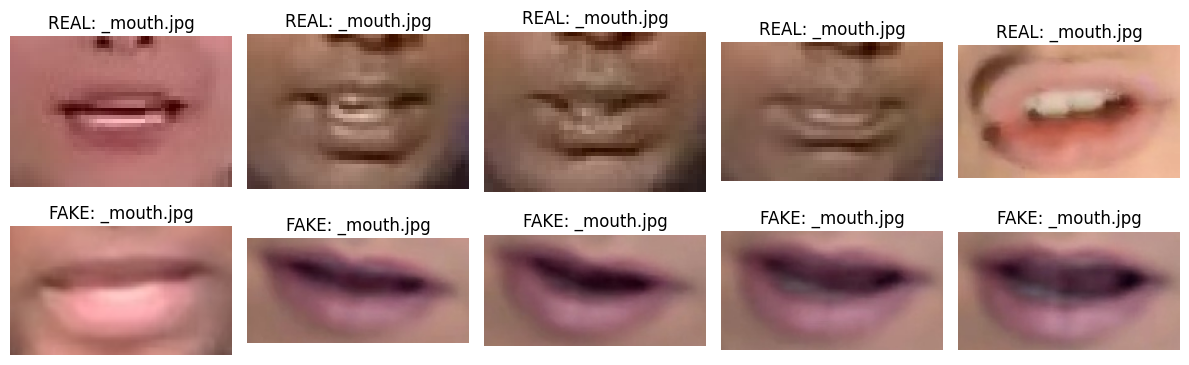

In [ ]:
n = 5

# Get sorted file lists
real_files = sorted(os.listdir(real_mouth_dir))[:n]
fake_files = sorted(os.listdir(fake_mouth_dir))[:n]

# Show real images
plt.figure(figsize=(12, 4))
for i, fname in enumerate(real_files):
    img = Image.open(os.path.join(real_mouth_dir, fname))
    plt.subplot(2, n, i + 1)
    plt.imshow(img)
    plt.title(f"REAL: {fname[-10:]}")
    plt.axis("off")

# Show fake images
for i, fname in enumerate(fake_files):
    img = Image.open(os.path.join(fake_mouth_dir, fname))
    plt.subplot(2, n, n + i + 1)
    plt.imshow(img)
    plt.title(f"FAKE: {fname[-10:]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



In [ ]:
# Initialize dataset
transform = TransformWrapper(img_size=64)
mouth_dataset = Create_Dataset(real_mouth_dir, fake_mouth_dir, transform=transform)

if len(mouth_dataset) == 0:
    print("Error: No samples found.")
    exit()

# Create label
labels = np.array([lbl for _, lbl in mouth_dataset.samples])
indices = np.arange(len(mouth_dataset))

# Split data
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_dataset = Subset(mouth_dataset, train_idx)
val_dataset = Subset(mouth_dataset, val_idx)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Total samples: 24393
Train size: 19514, Val size: 4879


In [ ]:
model = CNN_ModelA(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/EECE7370/CNN_Mouth"
best_val_acc = 0.0

num_epochs = 36

for epoch in range(1, num_epochs + 1):
    # Train phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels_batch in train_loader:
        imgs = imgs.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    avg_train_loss = train_loss / total
    train_acc = correct / total

    # Val phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for imgs, labels_batch in val_loader:
            imgs = imgs.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels_batch)

            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct_val += (preds == labels_batch).sum().item()
            total_val += labels_batch.size(0)

    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    print(
        f"Epoch [{epoch}/{num_epochs}] "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Save best model
    if epoch > 10 and val_acc > best_val_acc:
        best_val_acc = val_acc
        model_filename = f"{save_path}_{best_val_acc:.4f}.pth"
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": best_val_acc,
        }, model_filename)
        print(f"! Best model updated and saved to {model_filename} (val_acc={best_val_acc:.4f})")

Epoch [1/36] Train Loss: 0.4497 | Train Acc: 0.7820 | Val Loss: 0.3578 | Val Acc: 0.8371
! Best model updated and saved to /content/drive/MyDrive/Colab Notebooks/EECE7370/CNN_Mouth_0.8371.pth (val_acc=0.8371)
Epoch [2/36] Train Loss: 0.3057 | Train Acc: 0.8679 | Val Loss: 0.3875 | Val Acc: 0.8473
! Best model updated and saved to /content/drive/MyDrive/Colab Notebooks/EECE7370/CNN_Mouth_0.8473.pth (val_acc=0.8473)
Epoch [3/36] Train Loss: 0.2460 | Train Acc: 0.8945 | Val Loss: 0.2270 | Val Acc: 0.9098
! Best model updated and saved to /content/drive/MyDrive/Colab Notebooks/EECE7370/CNN_Mouth_0.9098.pth (val_acc=0.9098)
Epoch [4/36] Train Loss: 0.2096 | Train Acc: 0.9148 | Val Loss: 0.2845 | Val Acc: 0.8885
Epoch [5/36] Train Loss: 0.1894 | Train Acc: 0.9230 | Val Loss: 0.1857 | Val Acc: 0.9256
! Best model updated and saved to /content/drive/MyDrive/Colab Notebooks/EECE7370/CNN_Mouth_0.9256.pth (val_acc=0.9256)
Epoch [6/36] Train Loss: 0.1715 | Train Acc: 0.9311 | Val Loss: 0.2288 | Va